# Analysis of Results
This notebook will look at the results of the multi-day training results of the Carla ARS agent. After visualizing and analyzing the results, there is discussion for future adjustments which could be made to try to improve upon the experiment, and also some commentary on the prospects of learning this complex task with ARS.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Compiling the Results
The log of the training is spread across four folders since it was halted 3 times along the way, so these logs are merged together to show the entire process. 

In [17]:
# Load separate log files into a list of pandas dataframes
logs = []
for i in range(1, 5):
    log = pd.read_csv('ARS_Carla/data/old_logs/2020-12-16_1250steps_part{}/log.txt'.format(i),
                      delim_whitespace=True
                     )
    logs.append(log)
logs[0].head()

,Time,Iteration,AverageReward,StdRewards,MaxRewardRollout,MinRewardRollout,Timesteps,LearningRate,DeltaStd
0,3381.079152,10,19.282374,9.546176,33.676427,-10.568525,11867,0.019801,0.029701
1,6717.330669,20,22.080483,11.244721,34.435285,-9.552600,22424,0.019604,0.029406
2,10074.364432,30,20.472664,13.626944,33.435207,-16.601753,33114,0.019409,0.029113
3,13333.280537,40,16.987832,14.808871,33.219910,-28.788938,43594,0.019215,0.028823
4,16649.656021,50,17.417661,13.009299,32.019467,-12.204136,54399,0.019024,0.028536


In [18]:
# For this dataframe to combine properly, the 'Time', 'Iteration', and 'Timesteps' columns must
# be added to the last row of the preceding log. This is done below.
log_df = pd.DataFrame()
for i in range(len(logs)):
    # Adding previous progress to each log
    if i > 0:
        logs[i]['Time'] += logs[i-1]['Time'].iloc[-1]
        logs[i]['Iteration'] += logs[i-1]['Iteration'].iloc[-1]
        logs[i]['Timesteps'] += logs[i-1]['Timesteps'].iloc[-1]
    # Concatenating into one log
    log_df = pd.concat([log_df, logs[i]], axis=0)
    
# Check tail to see if this worked properly, reset index and drop old
log_df.reset_index(inplace=True, drop=True)
log_df.tail()

,Time,Iteration,AverageReward,StdRewards,MaxRewardRollout,MinRewardRollout,Timesteps,LearningRate,DeltaStd
120,422862.917496,1210,3.193073,4.389879,11.773952,-7.977844,1251705,0.005960,0.008941
121,426439.339519,1220,1.560424,9.290763,39.450123,-12.104001,1262716,0.005901,0.008852
122,429991.512884,1230,4.701894,5.076052,16.661484,-3.954574,1273555,0.005842,0.008763
123,433553.477783,1240,1.137636,5.954079,11.756771,-13.953963,1284418,0.005784,0.008676
124,437147.757215,1250,2.139579,5.166459,16.296598,-8.625936,1295579,0.005727,0.008590


In [81]:
# Checking how many hours we trained for
train_hours = log_df.Time.iloc[-1] / 60 / 60
print('Trained for {} hours, equal to {} days.'.format(round(train_hours,2), 
                                                       round(train_hours/24, 2)))

Trained for 121.43 hours, equal to 5.06 days.


## Visualizing the Results

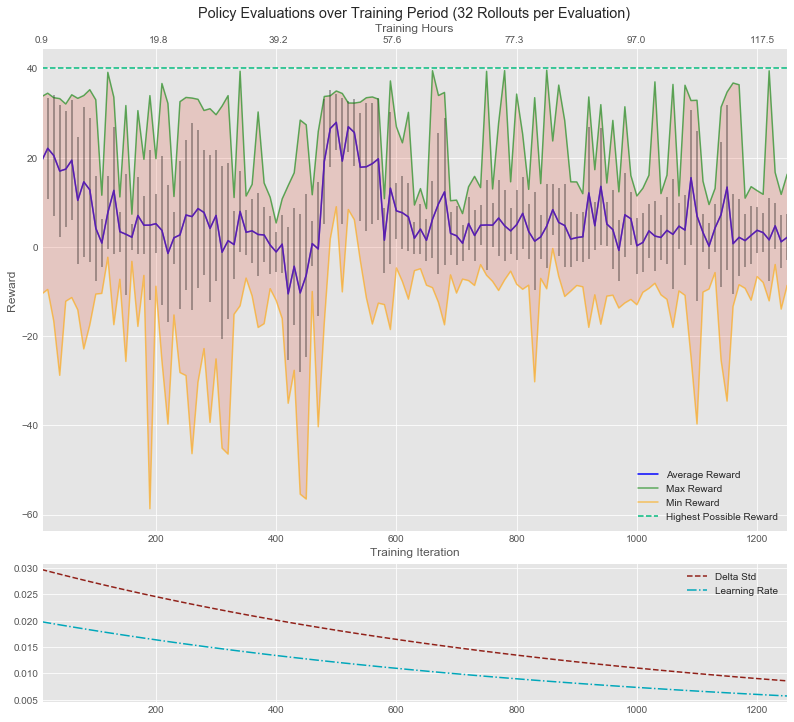

In [88]:
fig = plt.figure(figsize=(11, 10))
gs = fig.add_gridspec(nrows=4, ncols=1)

ax1 = fig.add_subplot(gs[:3, :])
ax1.set_xlim(log_df.Iteration.iloc[0], log_df.Iteration.iloc[-1])
ax1.plot(log_df.Iteration, log_df.AverageReward, color='blue', label='Average Reward')
ax1.plot(log_df.Iteration, log_df.MaxRewardRollout, color='green', label='Max Reward', alpha=0.6)
ax1.plot(log_df.Iteration, log_df.MinRewardRollout, color='orange', label='Min Reward', alpha=0.6)
ax1.errorbar(log_df.Iteration, log_df.AverageReward, yerr=log_df.StdRewards, ecolor='k', alpha=0.4)
ax1.fill_between(log_df.Iteration, log_df.MinRewardRollout, log_df.MaxRewardRollout, alpha=0.2)
ax1.axhline(40, ls='--', color='#00ba7c', label='Highest Possible Reward')
ax2 = ax1.twiny()
xticks2 = list(log_df[log_df.index % 20 == 0]['Time'] / 60 / 60)
ax2.set_xlim(xticks2[0], log_df.Time.iloc[-1] / 60 / 60)
ax1.set_xlabel('Training Iteration')
ax1.set_ylabel('Reward')
ax2.set_xlabel('Training Hours')
ax2.grid(False)
ax2.set_xticks(xticks2)
plt.title('Policy Evaluations over Training Period (32 Rollouts per Evaluation)')
ax1.legend()

ax3 = fig.add_subplot(gs[3:, :], sharex=ax1)
ax3.plot(log_df.Iteration, log_df.DeltaStd, ls='--', color='#912119', label='Delta Std')
ax3.plot(log_df.Iteration, log_df.LearningRate, ls='-.', color='#00a7ba', label='Learning Rate')
ax3.legend()

#ax4 = fig.add_subplot(gs[4, :], sharex=ax1)
#ax4.plot(log_df.Iteration, log_df.DeltaStd)

fig.tight_layout(pad=0.6)

## Discussion
We can see from the above chart that after 1250 training iterations, substantial progress was not made in the average rewards over the 32 rollouts of each evaluation step. There does seem to be a reduction in standard deviation of rewards over time, but without the desired increase in average reward. 

There is a slow decline in average reward in the early period of the training, then a spike upwards around 500 training iterations, after which there is another decline. This may be an indication that the learning rate is set too high for this task, and more testing using different learning rates is appropriate based on these results. It may also be an indication that the delta std was set too high as well, which also needs to be further tested.

The minimum rewards do seem to increase over time, with much more extreme low values in the first portion of the training period. The agent was penalized for large steering control values, so this may be the period before it adjusted the weights enough to prevent extreme values for this control.

The maximum achievable reward for any rollout is 40, and we can see that individual rollouts were periodically getting to this level. This is a good time to dive into the issue of varying circumstances which our workers find themselves in after being dropped into the map. Currently, each worker is spawned at a random location on the map, and the resulting reward from the worker's behavior is highly related to the location where it was spawned. A worker spawned with an open stretch of road could get close to a max score by flooring it and not steering, while the same behavior at a different spawn point would result in a crash, and therefore a punishment. This makes it difficult for the algorithm to fairly evaluate the efficacy of each adjustment to the weights, since pure luck is playing such a large role in how well the episode goes, and therefore to the contribution of each delta to the update step. This should be dealt with in the future, and a good start would be to spawn the worker testing a given delta in the same location for the positive and negative addition of that delta, so that the rewards being compared in the update step were generated under identical conditions. This would lead to more meaningful contributions of each delta in the update step.

## Conclusions
In this study, a usable framework for training a self-driving car policy using ARS in Carla has been constructed. Although an effective policy was not achieved after the first round of training, many insights about how to improve these results in the future have been obtained. The learning framework created provides the opportunity to easily apply these insights in the future.

The first issue to address is the variability of circumstances that workers find themselves placed into during training steps. A great first step would be to have the positive and negative addition of each delta tested from the same spawning location on the map, to generate more fair and meaningful comparisons in the update step. 

Another point to consider is that the BipedalWalker, which has the advantage of being placed in the exact same scenario for every episode, still took around 600 episodes before the training process started having noticeable effects on the rewards. Considering how many unique situations the workers in this study are exposed to in the Carla simulator, it may not be surprising that meaningful performance gains were not achieved after 1250 training steps, and it is possible that allowing the agent more time to train may have ultimately paid off with an effective policy. In the future, training the agent with more computational resources would help answer this question, since more workers could be operating simultaneously and dividing the work up more ways, which would decrease the overall time requirement for each update step.

In this study, the brake and throttle were kept as separate controls, but it may have been more appropriate to combine them into one continuous control value between -1 and +1, since that would prevent them being applied at the same time no matter how the weights were adjusted, and would provide a more realistic representation of how human beings apply these controls. 

Tweaking the reward system may also lead to better learning by the agent, especially the size of punishment for collisions. The agent will not be able to learn correct behavior for the edge-cases leading up to a collision without experiencing those collisions, so it may be appropriate to reduce the collision punishment so that the agents feel more free to explore these scenarios, but not so much that it does not then alter the policy to avoid similar collisions in the future.

The next thing to work on would be to test more values for the hyperparameters and compare the results of each, which again could be much better done using larger hardware than the gaming laptop used in this study, since training time could be drastically reduced by having more workers in parallel. Smaller values for learning rate should be explored, since we saw decreasing average rewards in the early period of this training session, which could be an indication that learning rate was too large. Further, the number of deltas generated as well as the number of them that are used in the update step could be altered to observe the effects on training.

The VGG19 CNN was chosen as an intermediary step between the camera and ARS perceptron to serve as a way to convert raw camera data (which, if left untreated is likely to cause overfitting to very specific RGB combinations) to edge-case information, which may be more generalized. This part of the process needs more experimentation, as other networks or weights could have been chosen. The top layer was not included on the CNN, though it could be interesting to see what difference the inclusion of this layer might make. As it was, the CNN produced a prediction array with shape (7, 7, 512), which was flattened into shape (25088,) on its way into the perceptron. Although much smaller than the (150528,) shape one would get by flattening the (224, 224, 3) RGB camera sensor data, this is still a big input layer, with a large number of specific arrangements that the agent could only evaluate its policy against in the event that it experienced them. Even in our completely sterilized task of driving around empty streets on the same map with consistent lighting, it would be difficult for an agent to encounter each of these edge-cases frequently enough to properly tune the weights to suit them without training for very long periods of time. Research into how to generalize these edge-cases is warranted. It is very possible that using some kind of pooling layer(s) on the end of the CNN would help in this regard. It must also be acknowledged that many of these inputs may be zero throughout much of the training process, and therefore the weights associated with them would be having no effect on performance, leaving them vulnerable to being modified willy-nilly by the update steps. More consideration needs to be made with regard to this, and again this may be relieved with some type of dimensionality reduction such as pooling layers.

Variable weather was not used in this study, and the agent was only trained on one map, with no traffic or pedestrians. This was acceptable for giving ARS a chance to show its ability in the domain of autonomous driving, but further research would need to be done involving these variables.

This study only involved sensor data from one forward-facing camera per car with a field-of-view (FOV) of 110 degrees to train the agent. It may be worthwhile to run the same test again with a FOV of 180 degrees to compare the results. It would also be interesting to explore the addition of more cameras or sensors of other types to the vehicle, including radar, lidar, and GPS, all of which are available in Carla. An added rear camera would be a logical next step. The data from these sensors could be combined and processed in a variety of ways to facilitate learning of any task related to autonomous driving.

The task at hand in this study was relatively simple for this domain: drive around empty streets without smashing into anything, using edge depictions generated by a CNN from RGB camera sensor input. In reality, there are many individual tasks within the context of autonomous driving that researchers seek to accomplish using machine learning and sensory input, including object detection/classification, determination of drivable area, trajectory planning, localization, and many more. The ARS algorithm is used to train agents to perform continuous control locomotion tasks using a single-layer perceptron on a given set of inputs, and it is likely that this capability would be facilitated by including among these inputs the predictions of models pre-trained to perform these specific driving-related tasks, and more research is warranted to explore such possible input configurations to the algorithm.

The safety and scalability of learning in a simulated environment such as Carla provides the opportunity to asses the potential of various combinations of learning algorithms and sensory input configurations to perform a given task or set of tasks. Once models are trained to effectively perform these individual tasks using the sensor data, their outputs may then be combined and passed as inputs into RL algorithms such as ARS to train autonomous navigation policies. The computational simplicity of ARS makes it possible to perform more simultaneous virtual training operations using a given set of inputs for any given amount of available computational resources, allowing for the efficacy of an input schema to be evaluated in a timely fashion. This means that ARS has the potential to expedite the discovery of powerful ways to combine sensory input and intermediary task-specific models to facilitate policy training. The learning framework constructed in this study can offer future researchers a structural foundation on which to explore these possibilities.

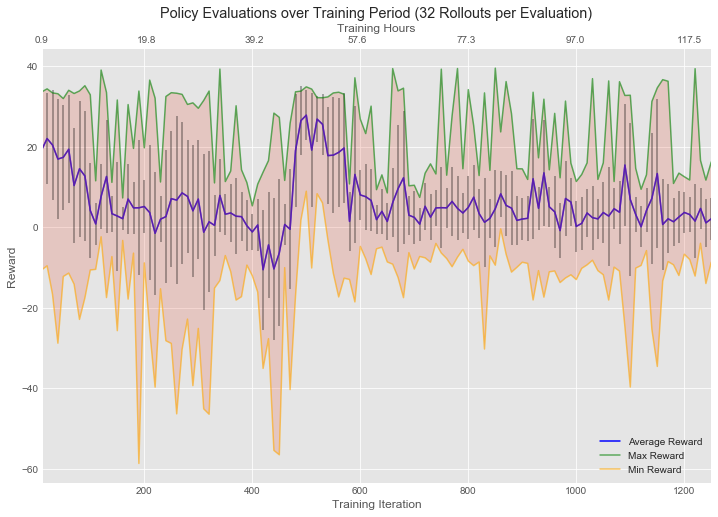

In [61]:
# Code to produce single graph without learning rate and delta std curves
plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax1.set_xlim(log_df.Iteration.iloc[0], log_df.Iteration.iloc[-1])
ax1.plot(log_df.Iteration, log_df.AverageReward, color='blue', label='Average Reward')
ax1.plot(log_df.Iteration, log_df.MaxRewardRollout, color='green', label='Max Reward', alpha=0.6)
ax1.plot(log_df.Iteration, log_df.MinRewardRollout, color='orange', label='Min Reward', alpha=0.6)
ax1.errorbar(log_df.Iteration, log_df.AverageReward, yerr=log_df.StdRewards, ecolor='k', alpha=0.4)
ax1.fill_between(log_df.Iteration, log_df.MinRewardRollout, log_df.MaxRewardRollout, alpha=0.2)
ax2 = ax1.twiny()
xticks2 = list(log_df[log_df.index % 20 == 0]['Time'] / 60 / 60)
ax2.set_xlim(xticks2[0], log_df.Time.iloc[-1] / 60 / 60)
ax1.set_xlabel('Training Iteration')
ax1.set_ylabel('Reward')
ax2.set_xlabel('Training Hours')
ax2.grid(False)
ax2.set_xticks(xticks2)
plt.title('Policy Evaluations over Training Period (32 Rollouts per Evaluation)')
ax1.legend();